In [6]:
!python3 --version

Python 3.10.6


In [2]:
import talib
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns

from ta import add_all_ta_features
from ta.utils import dropna
from pyspark.context import SparkContext
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import lag
from pyspark.sql.functions import col

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

input_file = open('../data/ADA_USDT-1h.json')
json_array = json.load(input_file)

# OHLCV

df = pd.DataFrame(json_array)
df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
df['Coin'] = "ADA"
df.tail()

ModuleNotFoundError: No module named 'talib'

In [4]:
df['index'] = df.index

# Ema 89 strategy
df['EMA89High']=ta.ema(df.High, length=89)
df['EMA89Low']=ta.ema(df.Low, length=89)

df['SMA5'] = ta.sma(df.Close, length=5)
df['SMA200'] = ta.sma(df.Close, length=200)

# df['MA50'] = ta.sma(df.Close, length=50)
# df['MA100'] = ta.sma(df.Close, length=100)

df['EMA200']=ta.ema(df.Close, length=200)
df['EMA150']=ta.ema(df.Close, length=150)
df['EMA100']=ta.ema(df.Close, length=100)
df['EMA50']=ta.ema(df.Close, length=50)

df['EMA32']=ta.ema(df.Close, length=26)
df['EMA21']=ta.ema(df.Close, length=21)
df['EMA13']=ta.ema(df.Close, length=13)

df['RSI']=ta.rsi(df.Close, length=14)


df['Time'] = pd.to_datetime(df['Time'], unit='ms')
df['1h%'] = (df['Close'].pct_change(periods=1).mul(100))
df['4h%'] = (df['Close'].pct_change(periods=4).mul(100))
df['8h%'] = (df['Close'].pct_change(periods=8).mul(100))

# df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
# df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume_BTC")

df.tail()

NameError: name 'df' is not defined

In [140]:
# Create PySpark DataFrame from Pandas
sdf = spark.createDataFrame(df)
sdf = sdf.na.drop(how='any', thresh=None, subset=None)
sdf.printSchema()
sdf.select(*[
    (
        F.count(F.when((F.isnan(c) | F.col(c).isNull()), c)) if t not in ("timestamp", "date")
        else F.count(F.when(F.col(c).isNull(), c))
    ).alias(c)
    for c, t in sdf.dtypes if c in sdf.columns
]).show()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


root
 |-- Time: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Coin: string (nullable = true)
 |-- index: long (nullable = true)
 |-- EMA89High: double (nullable = true)
 |-- EMA89Low: double (nullable = true)
 |-- SMA5: double (nullable = true)
 |-- SMA200: double (nullable = true)
 |-- MA50: double (nullable = true)
 |-- MA100: double (nullable = true)
 |-- EMA200: double (nullable = true)
 |-- EMA150: double (nullable = true)
 |-- EMA100: double (nullable = true)
 |-- EMA50: double (nullable = true)
 |-- EMA32: double (nullable = true)
 |-- EMA21: double (nullable = true)
 |-- EMA13: double (nullable = true)
 |-- RSI: double (nullable = true)
 |-- 4h%: double (nullable = true)
 |-- 1h%: double (nullable = true)
 |-- 8h%: double (nullable = true)

+----+----+----+---+-----+------+----+-----+---------+--------+----+----

In [138]:
# price_window = Window.partitionBy('Coin').orderBy('Time')
# sdf = sdf.withColumn("prev_value", F.lag(sdf.Close).over(price_window))
# sdf = sdf.na.drop(how='any', thresh=None, subset=None)
# sdf = sdf.withColumn('perc_change', F.round((sdf.Close - sdf.prev_value) / F.abs(sdf.prev_value) * 100, 4))

# sdf.drop("prev_value")
# sdf.orderBy(col("perc_change").desc()).select("1h%","perc_change","Close","Open","Time").orderBy('Time').show()

22/10/06 17:35:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+--------------------+-----------+-----+-----+-------------------+
|                 1h%|perc_change|Close| Open|               Time|
+--------------------+-----------+-----+-----+-------------------+
| -1.0195412064570974|    -1.0195|1.165|1.177|2022-01-09 08:00:00|
|-0.42918454935623185|    -0.4292| 1.16|1.166|2022-01-09 09:00:00|
| 0.34482758620688614|     0.3448|1.164|1.161|2022-01-09 10:00:00|
|-0.08591065292095079|    -0.0859|1.163|1.164|2022-01-09 11:00:00|
|                 0.0|        0.0|1.163|1.162|2022-01-09 12:00:00|
| -0.6878761822871837|    -0.6879|1.155|1.163|2022-01-09 13:00:00|
|  0.5194805194805197|     0.5195|1.161|1.155|2022-01-09 14:00:00|
| 0.17226528854434875|     0.1723|1.163| 1.16|2022-01-09 15:00:00|
|  2.2355975924333693|     2.2356|1.189|1.163|2022-01-09 16:00:00|
|               

In [145]:
sdf.withColumn("range", 
          F.when(sdf['8h%'] > 0 & sdf['8h%'] <= 5, F.lit("0-5"))
            .otherwise(
              F.when(sdf['8h%'] > 5 & sdf['8h%'] <= 8, lit("5-8")).otherwise(F.lit("others"))
            )
            .otherwise(F.lit(">8"))
         ).groupBy("range").agg(sum(sdf['8h%'])).orderBy("range").show

Py4JError: An error occurred while calling o5283.and. Trace:
py4j.Py4JException: Method and([class java.lang.Integer]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)



In [21]:
# Add indicators strategies
def bullish_indicator(row):
 row['MA50'] > row['MA100']: return "Bullish"
 return "Bearish"

df['bullish_indicator'] = df.apply(lambda row: bullish_indicator(row), axis=1)


SyntaxError: invalid syntax (4150372299.py, line 3)

In [57]:
def addemasignal(df):
    emasignal = [0]*len(df)
    for i in range(0, len(df)):
        if df.EMA2[i]>df.EMA[i]:
            emasignal[i]=2
        elif df.EMA2[i]<df.EMA[i]:
            emasignal[i]=1
    df['EMASignal'] = emasignal

addemasignal(df)

In [58]:
def addorderslimit(df, percent):
    ordersignal=[0]*len(df)
    for i in range(1, len(df)): #EMASignal of previous candle!!! modified!!!
        if  df.Close[i]<=df['BBL_14_2.0'][i] and df.EMASignal[i]==2:
            ordersignal[i]=df.Close[i]-df.Close[i]*percent
        elif df.Close[i]>=df['BBU_14_2.0'][i] and df.EMASignal[i]==1:
            ordersignal[i]=df.Close[i]+df.Close[i]*percent
    df['ordersignal']=ordersignal
    
addorderslimit(df, 0.000)

In [59]:
df[df.ordersignal!=0]

,index,Date,Open,High,Low,Close,Adj Close,Volume,EMA,EMA2,RSI,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0,EMASignal,ordersignal
49,248,2020-09-05,388.038391,394.172272,316.774353,335.260071,335.260071,29880047640,268.359592,291.964020,36.268771,337.465630,402.726118,467.986606,32.409365,-0.016898,2,335.260071
67,266,2020-09-23,344.589905,344.671387,318.969208,321.116302,321.116302,12899346599,283.953657,307.119985,35.267135,329.503629,367.204104,404.904579,20.533798,-0.111236,2,321.116302
220,419,2021-02-23,1781.409058,1781.409058,1378.840942,1570.203979,1570.203979,52029864713,867.696970,994.366944,40.837993,1627.356914,1821.787912,2016.218909,21.345075,-0.146975,2,1570.203979
222,421,2021-02-25,1625.393921,1670.224121,1465.058960,1475.703735,1475.703735,24481681873,881.222686,1009.004982,37.469127,1513.738582,1791.376343,2069.014103,30.997145,-0.068497,2,1475.703735
247,446,2021-03-22,1788.362183,1811.968262,1674.299805,1691.333984,1691.333984,23599296129,1065.059650,1209.122841,45.084565,1709.724922,1811.396467,1913.068012,11.225764,-0.090443,2,1691.333984
248,447,2021-03-23,1690.871826,1725.108765,1662.539917,1678.650146,1678.650146,21998237965,1071.165028,1215.341746,44.166295,1680.723780,1797.867990,1915.012199,13.031458,-0.008851,2,1678.650146
249,448,2021-03-24,1678.002563,1740.428223,1570.787964,1593.413452,1593.413452,31228051473,1076.361530,1220.349318,38.428324,1625.685960,1783.171361,1940.656761,17.663518,-0.102462,2,1593.413452
305,504,2021-05-19,3382.657227,3437.935791,1952.460205,2460.679199,2460.679199,84482912776,1793.775843,2042.681100,34.275799,2807.368032,3632.637608,4457.907184,45.436383,-0.210046,2,2460.679199
338,537,2021-06-21,2245.317871,2259.464111,1867.185425,1888.447510,1888.447510,33745173825,1989.472050,2200.718173,31.420723,1999.297184,2376.100481,2752.903779,31.716108,-0.147092,2,1888.447510
339,538,2021-06-22,1886.667603,1993.159790,1707.600586,1874.950073,1874.950073,35547251725,1988.332528,2196.403364,31.142013,1883.435034,2330.208435,2776.981836,38.346218,-0.009496,2,1874.950073


In [60]:
import numpy as np
def pointposbreak(x):
    if x['ordersignal']!=0:
        return x['ordersignal']
    else:
        return np.nan
df['pointposbreak'] = df.apply(lambda row: pointposbreak(row), axis=1)

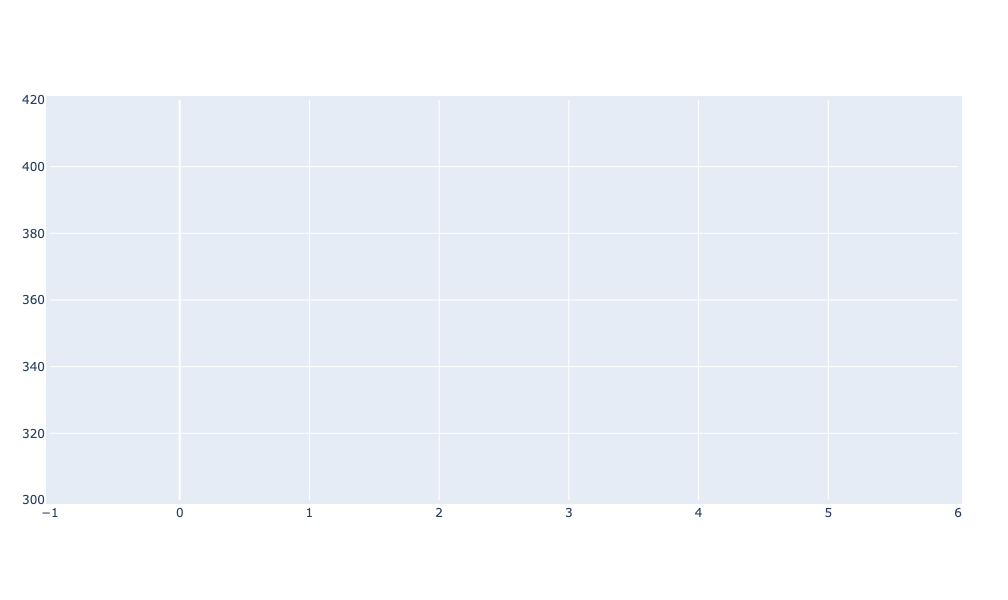

In [61]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

dfpl = df[1000:3200].copy()
#dfpl=dfpl.drop(columns=['level_0'])#!!!!!!!!!!
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),
                go.Scatter(x=dfpl.index, y=dfpl.EMA, line=dict(color='orange', width=2), name="EMA"),
                go.Scatter(x=dfpl.index, y=dfpl.EMA2, line=dict(color='yellow', width=2), name="EMA2"),        
                go.Scatter(x=dfpl.index, y=dfpl['BBL_14_2.0'], line=dict(color='blue', width=1), name="BBL"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_14_2.0'], line=dict(color='blue', width=1), name="BBU")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointposbreak'], mode="markers",
                marker=dict(size=6, color="MediumPurple"),
                name="Signal")
fig.update(layout_yaxis_range = [300,420])
fig.update_xaxes(rangeslider_visible=False)
fig.update_layout(autosize=False, width=600, height=600,margin=dict(l=50,r=50,b=100,t=100,pad=4), paper_bgcolor="white")
fig.show()

In [62]:
dfpl = df[:].copy()
def SIGNAL():
    return dfpl.ordersignal

In [63]:
from backtesting import Strategy
from backtesting import Backtest

class MyStrat(Strategy):
    initsize = 0.99
    mysize = initsize
    def init(self):
        super().init()
        self.signal = self.I(SIGNAL)

    def next(self):
        super().next()
        TPSLRatio = 2
        perc = 0.02
        
        if len(self.trades)>0:
            if self.data.index[-1]-self.trades[-1].entry_time>=10:
                self.trades[-1].close()
            if self.trades[-1].is_long and self.data.RSI[-1]>=75:
                self.trades[-1].close()
            elif self.trades[-1].is_short and self.data.RSI[-1]<=25:
                self.trades[-1].close()
        
        if self.signal!=0 and len(self.trades)==0 and self.data.EMASignal==2:  
            sl1 = min(self.data.Low[-1],self.data.Low[-2])*(1-perc)
            tp1 = self.data.Close[-1]+(self.data.Close[-1] - sl1)*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal!=0 and len(self.trades)==0 and self.data.EMASignal==1:         
            sl1 = sl1 = max(self.data.High[-1],self.data.High[-2])*(1+perc)
            tp1 = self.data.Close[-1]-(sl1 - self.data.Close[-1])*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfpl, MyStrat, cash=1000, margin=1/5, commission=.000)
stat = bt.run()
stat

/tmp/ipykernel_19528/3475104714.py:34: UserWarning:

Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).

/tmp/ipykernel_19528/3475104714.py:34: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                     0.0
End                                     775.0
Duration                                775.0
Exposure Time [%]                    3.092784
Equity Final [$]                   300.744607
Equity Peak [$]                   2471.336641
Return [%]                         -69.925539
Buy & Hold Return [%]              573.582084
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -87.83069
Avg. Drawdown [%]                  -52.724208
Max. Drawdown Duration                  554.0
Avg. Drawdown Duration                  279.0
# Trades                                  8.0
Win Rate [%]                             37.5
Best Trade [%]                      14.781631
Worst Trade [%]                    -21.569902
Avg. Trade [%]                    

In [64]:
bt.plot()

Row(id='2634', ...)